# Inference of Anomaly Cross Correlation skill in multi-year hindcast evaluation

A demonstration using synthetic, independent (AR) "hindcast" and "observed" series.

**Please chime in at any point**

In [1]:
import numpy as np

import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from src import utils, plot, stats, ar_model

In [6]:
DATA_DIR = "../../data/processed"

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12

## We construct some synthetic series by fitting an Autoregressive model to a climate index calculated from reanalysis data. 

E.g. let's focus on the Boreal Winter Atlantic multidecadal variability index computed from HadISST

In [12]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).compute()

The synthetic observations are generated by randomly drawing $N_{time}$ samples of the AR model

The synthetic ensemble hindcasts are generated by running the model forward in time from $N_{time}$ randomly drawn samples of the AR model. The initial condition for each $N_{member}$ ensemble member is the same, but their trajectories differ because the noise component is different for each member.

Below, I generate $N_{sample}=5000$ pairs of such signals

In [13]:
N_time = 45
N_samples = 5000
N_members = 40
rolling_means = [4, 8]

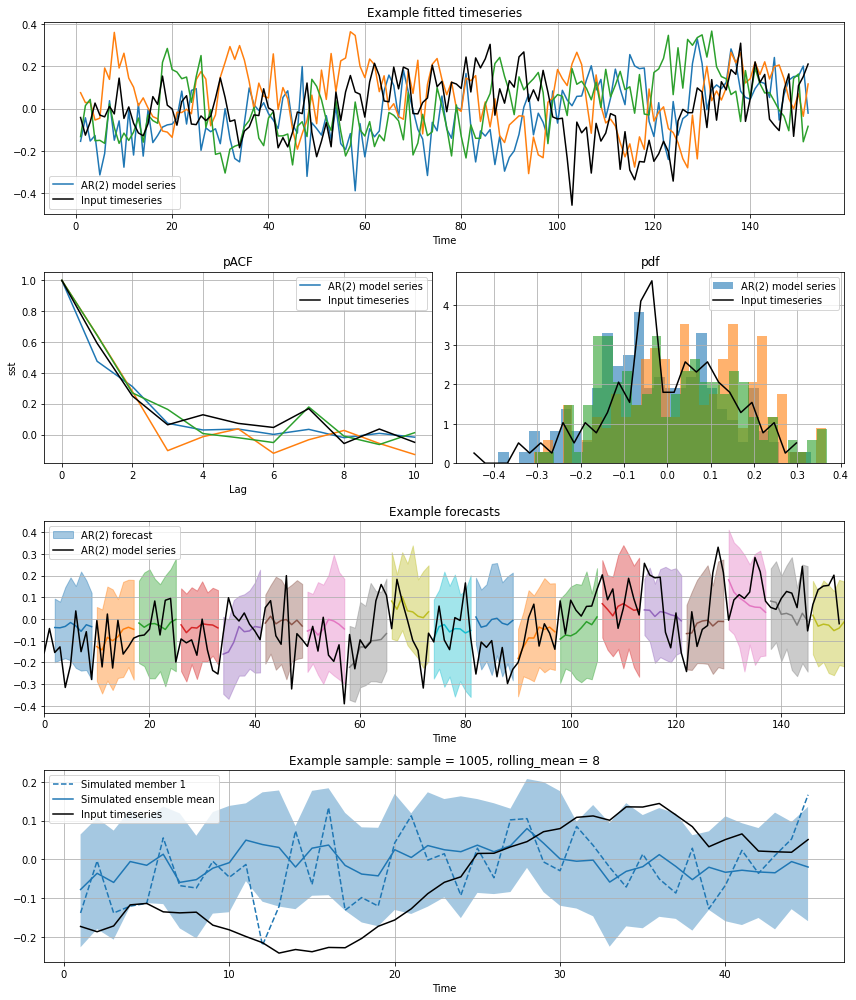

In [14]:
input_data = AMV

fcst = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    n_members=N_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

obsv = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

Here we focus on 8-year rolling means, which is commonplace in the literature. 

The rolling means are computed along **time** for the synthetic observations and along **lead** for the synthetic hindcasts

## The approach that has emerged as standard for inferring the significance of skill metrics in the multi-year community is a block-bootstrapping approach using a fixed blocksize, $L$, of 5 points:

1. Randomly sample with replacement $N_{time}$ validation cases. To take autocorrelation into account, this is done in blocks of five consecutive cases.

2. For each case, randomly sample with replacement $N_{member}$ ensemble members.

3. Compute the required statistic for the ensemble mean (here we're interested in the ACC).

4. Repeat steps (1)–(3) $N_{iteration}$ times to create a probability distribution.

5. Obtain the significance level on the basis of a two-tailed test of the hypothesis that skill (ACC) is 0.

Let's do this for one of our pairs of synthetic observations/hindcasts

In [ ]:
rr, pval = stats.infer_metric(
    fcst.sel(rolling_mean=8),
    obsv.sel(rolling_mean=8),
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
    ),
)

In [ ]:
abs(pval.where(rr > 0) - 0.03).argmin().values

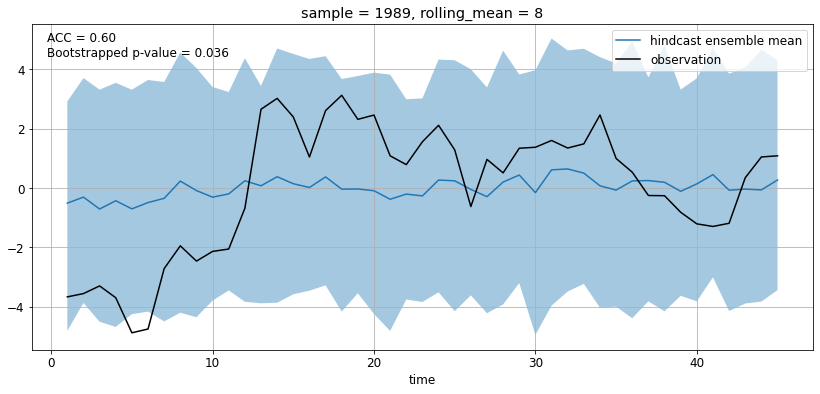

In [167]:
sample = 1989

fcst_samp = fcst.sel(rolling_mean=8, sample=sample)
fcst_plot = fcst_samp - fcst_samp.mean(["time", "member"])
obsv_samp = obsv.sel(rolling_mean=8, sample=sample)
obsv_plot = obsv_samp - obsv_samp.mean("time")

plt.fill_between(
    fcst_plot.time.values,
    fcst_plot.quantile(0.05, dim="member"),
    fcst_plot.quantile(0.95, dim="member"),
    color="C0",
    edgecolor="none",
    alpha=0.4,
)
(1 * fcst_plot.mean("member")).plot(color="C0", label="hindcast ensemble mean")
obsv_plot.plot(color="k", label="observation")

r, p = stats.infer_metric(
    fcst_samp,
    obsv_samp,
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
    ),
)
plt.text(
    0.02,
    0.90,
    f"ACC = {r.values:.2f}\nBootstrapped p-value = {p.values:.3f}",
    transform=plt.gca().transAxes,
)

plt.grid()
_ = plt.legend(loc="upper right")

Most multi-year verification studies assign significance for p-values less than 0.05, so for this sample, we would say that our hindcasts are skillful. 

Of course, it's not surprising that I can find examples of high correlation in my $N_{sample}$s of synthetic signals. However, the p-value estimated by the "standard" block bootstrap approach is far too low. Actually, correlations this high occur far more often than this p-value suggests.

In [168]:
stats.pearson_r(fcst.sel(rolling_mean=8), obsv.sel(rolling_mean=8)).max()

<xarray.DataArray ()>
array(0.68833422)
Coordinates:
    rolling_mean  int64 8

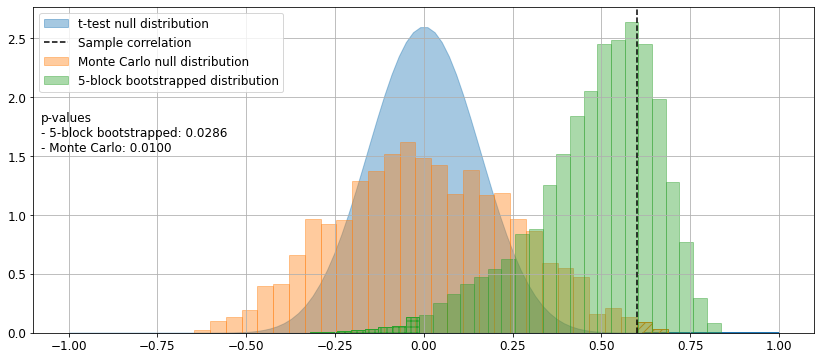

In [169]:
plot.pearson_r_distributions(
    fcst.sel(rolling_mean=8), obsv.sel(rolling_mean=8), sample, block=5
)

In [170]:
stats.get_Type_I_error_rates(
    fcst.sel(rolling_mean=8),
    obsv.sel(rolling_mean=8),
    n_times=[45],
    n_members=[169],
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
    ),
)

<xarray.DataArray (n_times: 1, n_members: 1)>
array([[0.0895]])
Coordinates:
    rolling_mean  int64 8
  * n_members     (n_members) int64 169
  * n_times       (n_times) int64 45

This is because $N_{time}$ is small and the serial correlation is high due to:

1. The nature of the process being assessed
2. The 8-year running averaging (largest effect on the observations)
3. The ensemble averaging

The effective sample size is very small and a blocksize of 5 is insufficient to account for the autocorrelation.

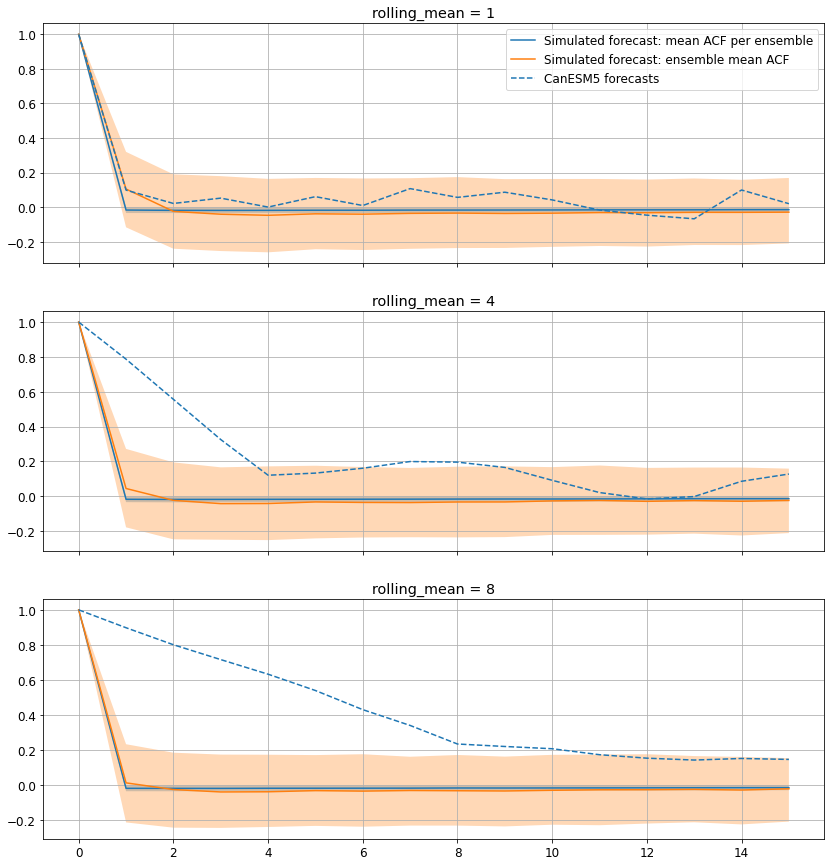

In [67]:
plot.acf(
    utils.detrend(fcst),
    utils.detrend(nao),
    headings=[
        "Simulated forecast",
        "CanESM5 forecasts",
    ],
    nlags=15,
)

The effective sample size for the 8-year rolling-mean series estimated by:

$N_{eff} = N \left( \frac{1 - \rho_{f} \rho_{o}}{1 + \rho_{f} \rho_{o}} \right)$

where $\rho_{f}$ and $\rho_{o}$ are the lag-1 autocorrelation coefficients for the forecasts and observations ([Bretherton et al. [1991]](https://doi.org/10.1175/1520-0442(1999)012<1990:TENOSD>2.0.CO;2)) is:

In [139]:
fcst_long = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=1000,
    n_samples=10,
    n_members=N_members,
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

obsv_long = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=1000,
    n_samples=10,
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

Neff = stats.effective_sample_size(
    fcst_long.mean("member"), obsv_long, fcst.sizes["time"]
).mean("sample")

print(f"N_eff = {Neff.values:.1f}")

N_eff = 8.4


The estimated blocksize, $L$, estimated by Wilks is (assuming the data follow a first-order regressive process):


In [146]:
print(f"L = {stats.blocklength_Wilks(55, 8)}")

L = 9


Using L = 9 has little impact on the above distribution and p-value. This is probably because these formula were derived for an AR(1) process (I think) which our's is not.

## How do error rates vary with $N_{time}$, $N_{member}$ and the width of the rolling mean?

In [ ]:
stats.get_Type_I_error_rates(
    fcst,
    obsv, 
    n_times=range(30, 170, 20),
    n_members=[1, 5, 10, 50],
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_permutations=1000, transform="Fisher_z"
    ),
)

Things I'm battling with:
 - Hard to convince be people that there is an issue using synthetic timeseries. Actually, I think many real-world cases are worse that the example case above. But real model data isn't long enough.

Things to maybe explore:
- How do different significance tests perform?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?